In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import math
import matplotlib.pyplot as plt
import seaborn as sns
import time

pd.options.display.max_rows=200
pd.options.display.max_columns=30

# real massIVE-KB vs pred maaIVE-KB

In [2]:
df_id_result = pd.read_csv('/data/210827_SJH_prosit/211025STRIP_PEP/massIVE-KB_result.tsv', sep='\t')
print(df_id_result.shape)
df_id_result.head(2)

(764191, 17)


,#SpecFile,SpecID,ScanNum,Title,FragMethod,Precursor,IsotopeError,PrecursorError(ppm),Charge,Peptide,Protein,DeNovoScore,MSGFScore,SpecEValue,EValue,QValue,PepQValue
0,massIVE-KB_predMS2_frac01.mgf,index=48780,-1,"48781 File:""massIVE-KB_predMS2_frac48781.mgf"",...",HCD,1148.54220,0,0.000000,3,ILGWGVENGTPYWLVANSWNTDWGDNGFFK,"sp|P07858|CATB_HUMAN(pre=R,post=I);tr|R4GMQ5|R...",218,213,3.842356e-39,1.063139e-31,0.0,0.0
1,massIVE-KB_predMS2_frac01.mgf,index=32978,-1,"32979 File:""massIVE-KB_predMS2_frac32979.mgf"",...",HCD,984.49884,0,0.061996,3,PYFLTDGTGTVTPANASGINDGAAAVVLMK,"sp|Q9BWD1|THIC_HUMAN(pre=K,post=K)",234,234,2.212097e-38,6.120636e-31,0.0,0.0


In [3]:
df_idreal_result = pd.read_csv('/data/210827_SJH_prosit/211025STRIP_PEP/real_massIVE-KB_result.tsv', sep='\t')
print(df_idreal_result.shape)
df_idreal_result.head(2)

(749848, 17)


,#SpecFile,SpecID,ScanNum,Title,FragMethod,Precursor,IsotopeError,PrecursorError(ppm),Charge,Peptide,Protein,DeNovoScore,MSGFScore,SpecEValue,EValue,QValue,PepQValue
0,massIVE-KB_frac01.mgf,index=34550,-1,"34551 File:""massIVE-KB_frac34551.mgf"", NativeI...",HCD,687.13104,0,0.088826,5,LQC+57.021PQVDLFYLHAPDHGTPVEETLHAC+57.021QR,"sp|O43488|ARK72_HUMAN(pre=R,post=L);tr|H7C5H7|...",210,210,1.029568e-37,2.834379e-30,0.0,0.0
1,massIVE-KB_frac01.mgf,index=36932,-1,"36933 File:""massIVE-KB_frac36933.mgf"", NativeI...",HCD,709.34720,0,0.086044,5,VIPDWKEQEWDPEKPNAYAGIFHFHFWR,"sp|O15484|CAN5_HUMAN(pre=K,post=F);tr|E7EV01|E...",213,209,1.315382e-37,3.602717e-30,0.0,0.0


In [4]:
df_id_result['Peptide'] = df_id_result.Peptide.apply(lambda x: x.replace('C+57.021', 'C'))
df_idreal_result['Peptide'] = df_idreal_result.Peptide.apply(lambda x: x.replace('C+57.021', 'C'))

In [5]:
def isDecoy(prot):
    prot_cnt = len(prot.split(';'))
    decoy_cnt = 0
    for p in prot.split(';'):
        if 'XXX' in p:
            decoy_cnt += 1
    if decoy_cnt == prot_cnt:
        return 'D'
    else:
        return 'T'

def getFDR(TD_list):
    start = time.time()
    
    FDR_list = []
    T_cnt = 0
    D_cnt = 0
    cut_idx = 0
    
    for idx, label in enumerate(TD_list):
        if label=='T':
            T_cnt += 1
        elif label == 'D':
            D_cnt += 1
        fdr = round((2*D_cnt) / (T_cnt + D_cnt), 2)
        if fdr <= 0.01:
            cut_idx = idx
    return cut_idx

def FDR_control(df, PERCENT):
    df_ = df.sort_values('SpecEValue').reset_index(drop=True)  # copy
    df_['TD_label'] = df_.Protein.apply(isDecoy).values
    print('********** Target Decoy Labelling Done **********')
    cut_idx = getFDR(df_.TD_label.values)  
    print('********** Calculating FDR Done **********')
    df_ = df_.iloc[:cut_idx+1].reset_index(drop=True)
    df_ = df_.loc[df_.TD_label=='T'].reset_index(drop=True)
    return df_

In [6]:
df_id_target = FDR_control(df_id_result, 0.01)
df_idreal_target = FDR_control(df_idreal_result, 0.01)

********** Target Decoy Labelling Done **********
********** Calculating FDR Done **********
********** Target Decoy Labelling Done **********
********** Calculating FDR Done **********


In [7]:
df_id_target_removeDecoy = df_id_target.copy()
p = []
for prot in df_id_target_removeDecoy.Protein.values:
    p.append(';'.join([_ for _ in prot.split(';') if 'XXX' not in _]))
df_id_target_removeDecoy['Protein'] = p
df_id_target_removeDecoy = df_id_target_removeDecoy.loc[df_id_target_removeDecoy.Protein!='']

df_idreal_target_removeDecoy = df_idreal_target.copy()
p = []
for prot in df_idreal_target_removeDecoy.Protein.values:
    p.append(';'.join([_ for _ in prot.split(';') if 'XXX' not in _]))
df_idreal_target_removeDecoy['Protein'] = p
df_idreal_target_removeDecoy = df_idreal_target_removeDecoy.loc[df_idreal_target_removeDecoy.Protein!='']

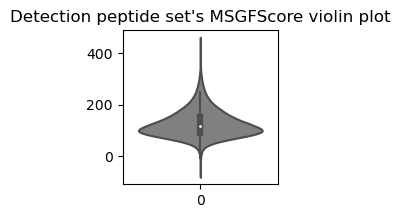

In [8]:
plt.figure(figsize=(2,2))
sns.violinplot(data=df_idreal_target_removeDecoy.MSGFScore.values, color='gray')
plt.title('Detection peptide set\'s MSGFScore violin plot')
plt.show()

In [9]:
df_id = pd.DataFrame([[_, 'ID', 'score'] for _ in df_id_target_removeDecoy.MSGFScore.values],
                     columns=['MSGFScore', 'label', 'score'])
df_idreal = pd.DataFrame([[_, 'idreal', 'score'] for _ in df_idreal_target_removeDecoy.MSGFScore.values],
                        columns=['MSGFScore', 'label', 'score'])
df_MSGFScore = pd.concat([df_idreal, df_id], axis=0).reset_index(drop=True)

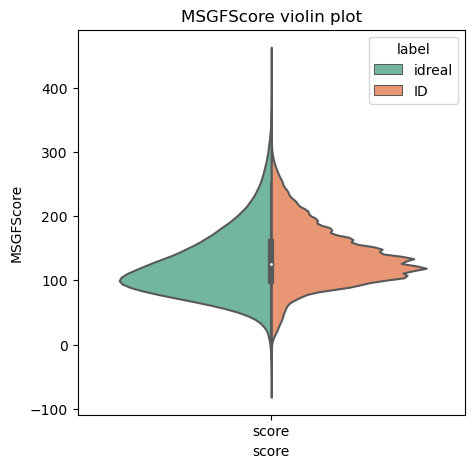

In [10]:
plt.figure(figsize=(5,5))
sns.violinplot(x='score', y="MSGFScore", hue="label",
                    data=df_MSGFScore, 
                    palette="Set2",
                    split=True,
                    scale="count"
                   )
plt.title('MSGFScore violin plot')
plt.show()

In [11]:
df_id_result['TD'] = df_id_result.Protein.apply(isDecoy)
df_idreal_result['TD'] = df_idreal_result.Protein.apply(isDecoy)

df_id_T = df_id_result.loc[df_id_result.TD=='T'].reset_index(drop=True)
df_idreal_T = df_idreal_result.loc[df_idreal_result.TD=='T'].reset_index(drop=True)

In [12]:
print(max(df_id_T.EValue.values), 
      min(df_id_T.EValue.values),  # maaIVE-KB
      max(df_idreal_T.EValue.values), 
      min(df_idreal_T.EValue.values))  # uniprot

127.47247 1.5074339925461614e-33 336.23285 7.06608911968213e-32


In [13]:
df_id_2d_T = pd.DataFrame([[len(p), m, se, e, 'ID', 'score'] 
                               for p, m, se, e in df_id_T[['Peptide', 'MSGFScore', 'SpecEValue', 'EValue']].values],
                        columns=['PeptideLength', 'MSGFScore', 'SpecEValue', 'EValue', 'Label', 'score'])
df_idreal_2d_T = pd.DataFrame([[len(p), m, se, e, 'idreal', 'score'] 
                               for p, m, se, e in df_idreal_T[['Peptide', 'MSGFScore', 'SpecEValue', 'EValue']].values],
                        columns=['PeptideLength', 'MSGFScore', 'SpecEValue', 'EValue', 'Label', 'score'])

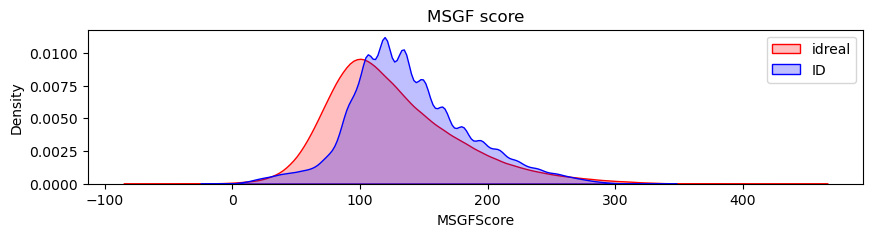

In [14]:
plt.figure(figsize=(10,2))
sns.kdeplot(df_idreal_2d_T.MSGFScore, shade=True, color='red')

sns.kdeplot(df_id_2d_T.MSGFScore, shade=True, color='blue')
plt.legend(['idreal', 'ID'])
plt.title('MSGF score')
plt.show()

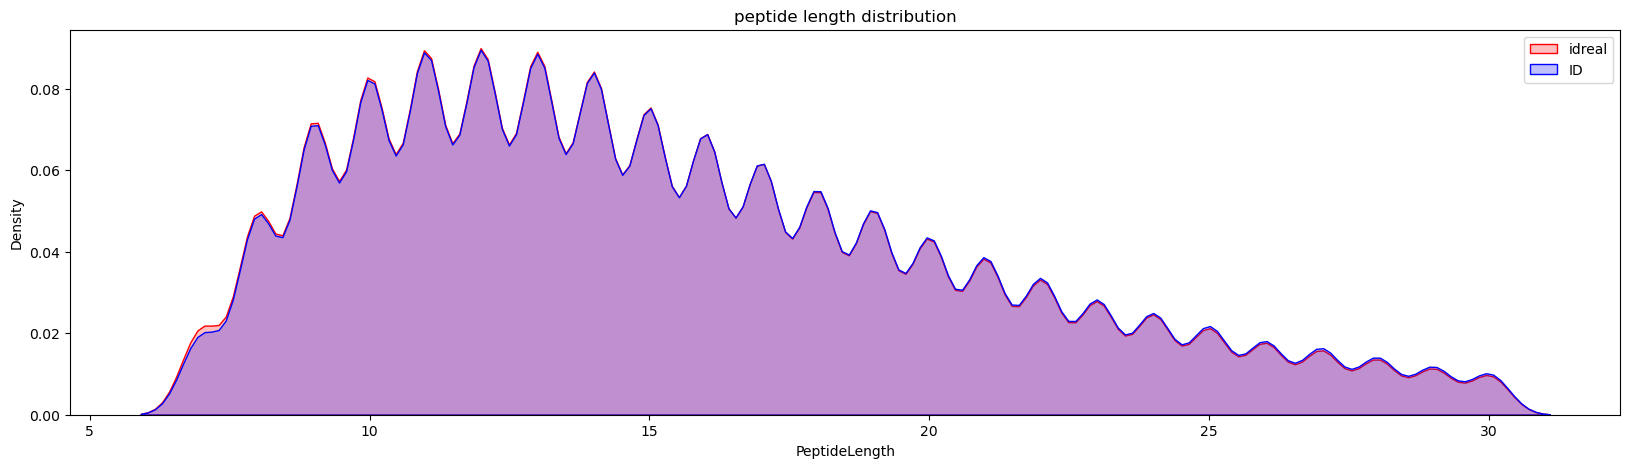

In [15]:
plt.figure(figsize=(20,5))
sns.kdeplot(df_idreal_2d_T.PeptideLength, shade=True, color='red')

sns.kdeplot(df_id_2d_T.PeptideLength, shade=True, color='blue')
plt.legend(['idreal', 'ID'])
plt.title('peptide length distribution')
plt.show()

In [16]:
df_idreal_2d_T['SpecEValue_log'] = df_idreal_2d_T.SpecEValue.apply(lambda x: -math.log(x))
df_id_2d_T['SpecEValue_log'] = df_id_2d_T.SpecEValue.apply(lambda x: -math.log(x))

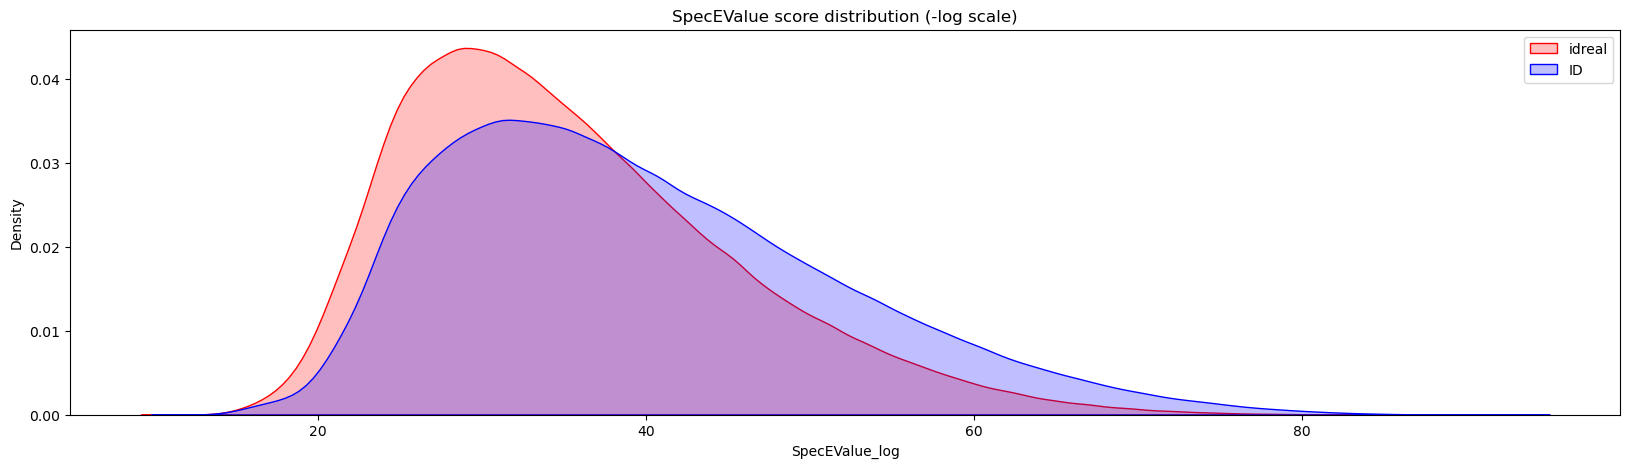

In [17]:
plt.figure(figsize=(20,5))
sns.kdeplot(df_idreal_2d_T.SpecEValue_log, shade=True, color='red')

sns.kdeplot(df_id_2d_T.SpecEValue_log, shade=True, color='blue')
plt.legend(['idreal', 'ID'])
plt.title('SpecEValue score distribution (-log scale)')
plt.show()

In [18]:
df_idreal_2d_T['EValue_log'] = df_idreal_2d_T.EValue.apply(lambda x: -math.log(x))
df_id_2d_T['EValue_log'] = df_id_2d_T.EValue.apply(lambda x: -math.log(x))

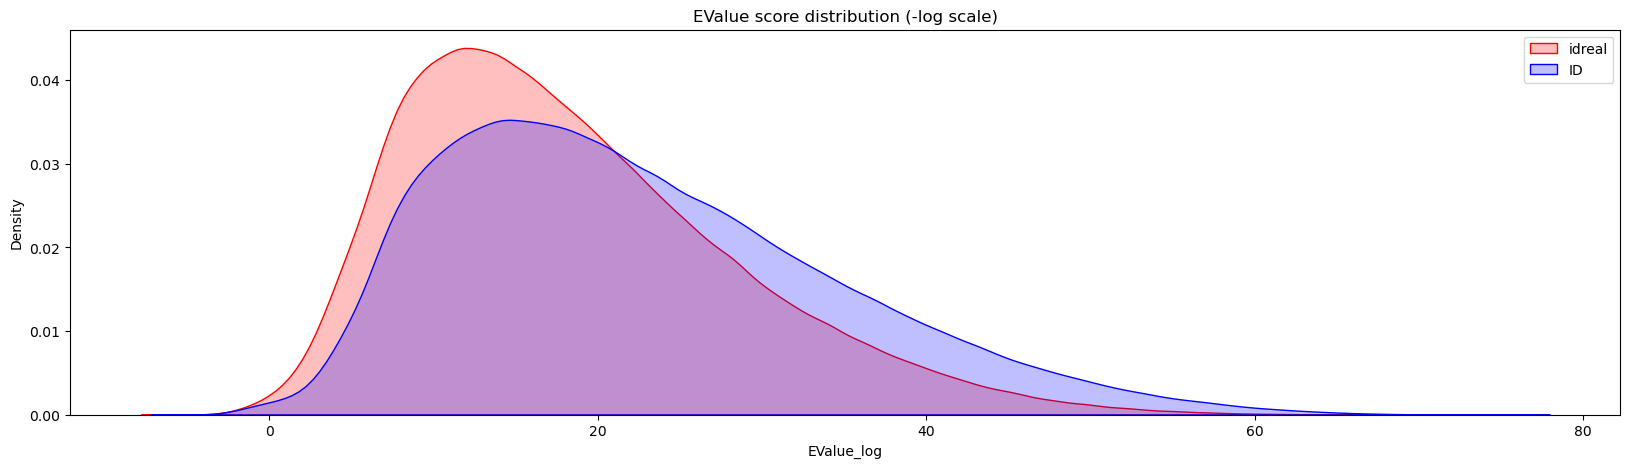

In [19]:
plt.figure(figsize=(20,5))
sns.kdeplot(df_idreal_2d_T.EValue_log, shade=True, color='red')

sns.kdeplot(df_id_2d_T.EValue_log, shade=True, color='blue')
plt.legend(['idreal', 'ID'])
plt.title('EValue score distribution (-log scale)')
plt.show()

In [20]:
print('id min max : ', min(df_id_2d_T.MSGFScore.values), max(df_id_2d_T.MSGFScore.values), 
      '\nnid min max : ', min(df_idreal_2d_T.MSGFScore.values), max(df_idreal_2d_T.MSGFScore.values))

id min max :  -16 339 
nid min max :  -75 456


# real spectrum vs pred spectrum

In [21]:
import pickle

with open('../data/massIVE-KB/211025_stirp_pep2spec_pred.pickle', 'rb') as f:
    pep2spec_pred = pickle.load(f)
with open('../data/massIVE-KB/211108_stirp_pep2spec.pickle', 'rb') as f:
    pep2spec = pickle.load(f)

In [22]:
df_id_T['KEY'] = df_id_T.Title.apply(lambda x: x.split()[0]).values
df_idreal_T['KEY'] = df_idreal_T.Title.apply(lambda x: x.split()[0]).values

df_id_key = pd.DataFrame([[str(_+1), 
                           ';'.join(list(map(str, dic.keys()))),
                           ';'.join(list(map(str, dic.values()))),
                           p,
                           c,
                           True] for _, ((p, c), dic) in enumerate(pep2spec_pred.items())],
                         columns=['KEY', 'MZ', 'INT', 'PEP', 'CHA', 'DROP'])
df_id_spec = df_id_T.merge(df_id_key, on='KEY', how='left').drop('DROP', axis=1)


df_id_key = pd.DataFrame([[str(_+1), 
                           ';'.join(list(map(str, dic.keys()))),
                           ';'.join(list(map(str, dic.values()))),
                           p,
                           c,
                           True] for _, ((p, c), dic) in enumerate(pep2spec.items())],
                         columns=['KEY', 'MZ', 'INT', 'PEP', 'CHA', 'DROP'])
df_idreal_spec = df_idreal_T.merge(df_id_key, on='KEY', how='left').drop('DROP', axis=1)



In [24]:
id_match_cnt = sum([1 for msgf_p, real_p in df_id_spec[['Peptide', 'PEP']].values if msgf_p == real_p])
print('pred실제 서열로 정답인 개수 ', id_match_cnt, '/', len(df_id_spec))
idreal_match_cnt = sum([1 for msgf_p, real_p in df_idreal_spec[['Peptide', 'PEP']].values if msgf_p.replace('L', 'I') == real_p.replace('L', 'I')])
print('real실제 서열로 정답인 개수 ', idreal_match_cnt, '/', len(df_idreal_spec))

pred실제 서열로 정답인 개수  761462 / 762999
real실제 서열로 정답인 개수  747134 / 748655


In [25]:
# mismatch peptide example
cnt = 0
for idx, (msgf_p, real_p) in enumerate(df_idreal_spec[['Peptide', 'PEP']].values):
    if cnt == 5:
        break
    if msgf_p.replace('L', 'I') != real_p.replace('L', 'I'):
        print(msgf_p, real_p)
        cnt += 1

NVVHQLSVTLEDLYNGATRK NVVHQLSVTLEDLYNGVTKK
KAEELIQQEHADQAEIR QAEELIQQEHADQAEIR
EHALLAYTLGVK ASLSNALDVLGKK
EQIKTLNNKFASFIDK EQIMVLNNKFASFIDK
FAVGTAGLGAEER YAAVVTPGLCAR


# real pred to dataframe

In [26]:
# x = pred
df_id_spec_x = df_id_spec[['Precursor', 'IsotopeError', 'PrecursorError(ppm)', 'Peptide', 'Protein', 'MSGFScore', 'SpecEValue', 'EValue', 'MZ', 'INT', 'PEP', 'CHA']]
df_id_spec_x.rename({'Precursor':'Precursor_pred', 'IsotopeError':'IsotopeError_pred',
                    'PrecursorError(ppm)': 'PrecursorError(ppm)_pred', 'Peptide':'Peptide_pred', 'Protein':'Protein_pred',
                    'MSGFScore':'MSGFScore_pred', 'SpecEValue':'SpecEValue_pred', 'EValue':'EValue_pred',
                    'MZ':'MZ_pred', 'INT':'INT_pred'}, axis=1, inplace=True)

# y = real
df_idreal_spec_y = df_idreal_spec[['Precursor', 'IsotopeError', 'PrecursorError(ppm)', 'Peptide', 'Protein', 'MSGFScore', 'SpecEValue', 'EValue', 'MZ', 'INT', 'PEP', 'CHA']]
df_idreal_spec_y.rename({'Precursor':'Precursor_real', 'IsotopeError':'IsotopeError_real',
                    'PrecursorError(ppm)': 'PrecursorError(ppm)_real', 'Peptide':'Peptide_real', 'Protein':'Protein_real',
                    'MSGFScore':'MSGFScore_real', 'SpecEValue':'SpecEValue_real', 'EValue':'EValue_real',
                    'MZ':'MZ_real', 'INT':'INT_real'}, axis=1, inplace=True)

/home/bis/miniconda3/envs/TF2.4/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [27]:
df_id_real_pred = df_id_spec_x.merge(df_idreal_spec_y, on=['PEP', 'CHA'], how='inner')
idxes = []
for idx, (predp, p, realp) in zip(df_id_real_pred.index, df_id_real_pred[['Peptide_pred', 'PEP', 'Peptide_real']].values):
    if predp == p and realp==p:
        idxes.append(idx)
df_id_real_pred = df_id_real_pred.loc[idxes].reset_index(drop=True)

print(df_id_real_pred.shape)
df_id_real_pred.head(2)

(744033, 22)


,Precursor_pred,IsotopeError_pred,PrecursorError(ppm)_pred,Peptide_pred,Protein_pred,MSGFScore_pred,SpecEValue_pred,EValue_pred,MZ_pred,INT_pred,PEP,CHA,Precursor_real,IsotopeError_real,PrecursorError(ppm)_real,Peptide_real,Protein_real,MSGFScore_real,SpecEValue_real,EValue_real,MZ_real,INT_real
0,1148.54220,0,0.000000,ILGWGVENGTPYWLVANSWNTDWGDNGFFK,"sp|P07858|CATB_HUMAN(pre=R,post=I);tr|R4GMQ5|R...",213,3.842356e-39,1.063139e-31,147.112804167;294.18121816699994;441.249632166...,0.24706785;0.4907155;0.21187675;0.36394352;0.4...,ILGWGVENGTPYWLVANSWNTDWGDNGFFK,3,1148.54220,0,0.000000,ILGWGVENGTPYWLVANSWNTDWGDNGFFK,"sp|P07858|CATB_HUMAN(pre=R,post=I);tr|R4GMQ5|R...",79,2.073257e-16,5.736481e-09,120.08077239990234;126.05509185791016;129.1025...,23000.103515625;14412.4521484375;16642.2246093...
1,984.49884,0,0.061996,PYFLTDGTGTVTPANASGINDGAAAVVLMK,"sp|Q9BWD1|THIC_HUMAN(pre=K,post=K)",234,2.212097e-38,6.120636e-31,147.112804167;278.15328916699997;391.237353167...,0.19555475;0.3118106;0.42195186;0.52578694;0.2...,PYFLTDGTGTVTPANASGINDGAAAVVLMK,3,984.49884,0,0.061996,PYFLTDGTGTVTPANASGINDGAAAVVLMK,"sp|Q9BWD1|THIC_HUMAN(pre=K,post=K)",212,8.474427e-31,2.344784e-23,120.08137512207031;129.1028594970703;130.08676...,21733.4375;22421.587890625;23938.779296875;607...


# 2d : real VS pred
 - msgf
 - evalue
 - specevalue

In [28]:
real_pred_msgf = df_id_real_pred[['MSGFScore_pred', 'MSGFScore_real']].values

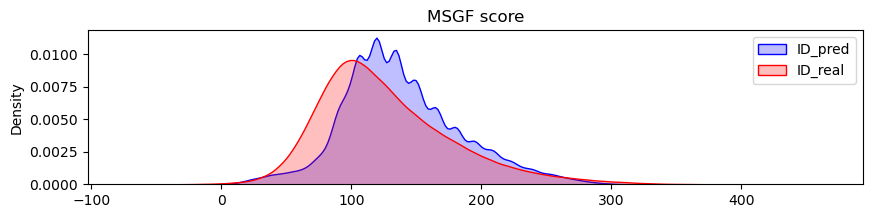

In [29]:
plt.figure(figsize=(10,2))
sns.kdeplot(real_pred_msgf[:, 0], shade=True, color='blue')  # pred

sns.kdeplot(real_pred_msgf[:, 1], shade=True, color='red')  # real
plt.legend(['ID_pred', 'ID_real'])
plt.title('MSGF score')
plt.show()

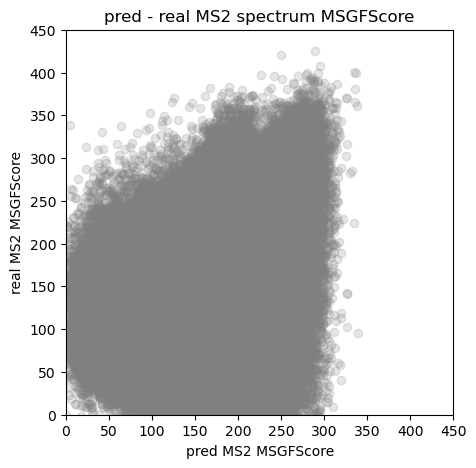

In [30]:
plt.figure(figsize=(5,5))
plt.scatter(real_pred_msgf[:, 0], real_pred_msgf[:, 1], color='gray', alpha=0.2)
plt.xlim(0, 450)
plt.ylim(0, 450)
plt.title('pred - real MS2 spectrum MSGFScore')
plt.xlabel('pred MS2 MSGFScore')
plt.ylabel('real MS2 MSGFScore')
plt.show()

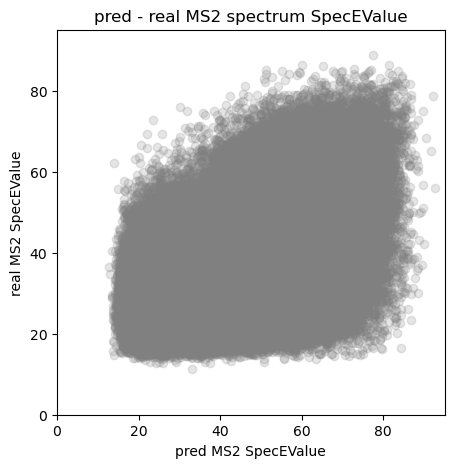

In [31]:
real_pred_SpecEValue = df_id_real_pred[['SpecEValue_pred', 'SpecEValue_real']].values

plt.figure(figsize=(5,5))
plt.scatter(list(map(lambda x: -math.log(x), real_pred_SpecEValue[:, 0])),
            list(map(lambda x: -math.log(x), real_pred_SpecEValue[:, 1])), color='gray', alpha=0.2)
plt.xlim(0, 95)
plt.ylim(0, 95)
plt.title('pred - real MS2 spectrum SpecEValue')
plt.xlabel('pred MS2 SpecEValue')
plt.ylabel('real MS2 SpecEValue')
plt.show()

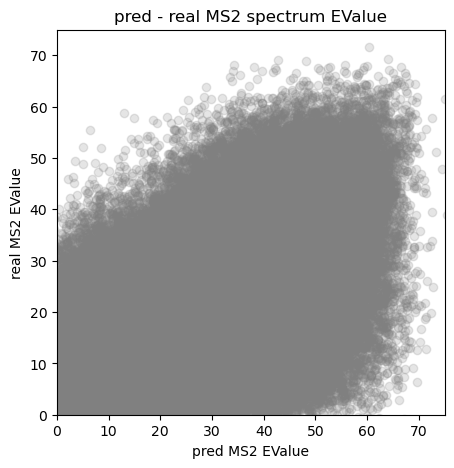

In [32]:
real_pred_EValue = df_id_real_pred[['EValue_pred', 'EValue_real']].values

plt.figure(figsize=(5,5))
plt.scatter(list(map(lambda x: -math.log(x), real_pred_EValue[:, 0])),
            list(map(lambda x: -math.log(x), real_pred_EValue[:, 1])), color='gray', alpha=0.2)
plt.xlim(0, 75)
plt.ylim(0, 75)
plt.title('pred - real MS2 spectrum EValue')
plt.xlabel('pred MS2 EValue')
plt.ylabel('real MS2 EValue')
plt.show()

# 3d : frequency axis add

In [33]:
# ss2freq = {(p, m):0 for p in range(7, 31) for m in range(-48, 356)}
ss2freq = dict()
for sp, sr in df_id_real_pred[['MSGFScore_pred', 'MSGFScore_real']].values:
    if (sp, sr) not in ss2freq:
        ss2freq[(sp, sr)] = 0
    ss2freq[(sp, sr)] += 1

In [34]:
df_id_real_pred_3d = pd.DataFrame([[int(sp), int(sr), f] for (sp, sr), f in ss2freq.items()],
                              columns=['MSGFScore_pred', 'MSGFScore_real', 'Frequency'])

In [35]:
%matplotlib notebook

<IPython.core.display.Javascript object>


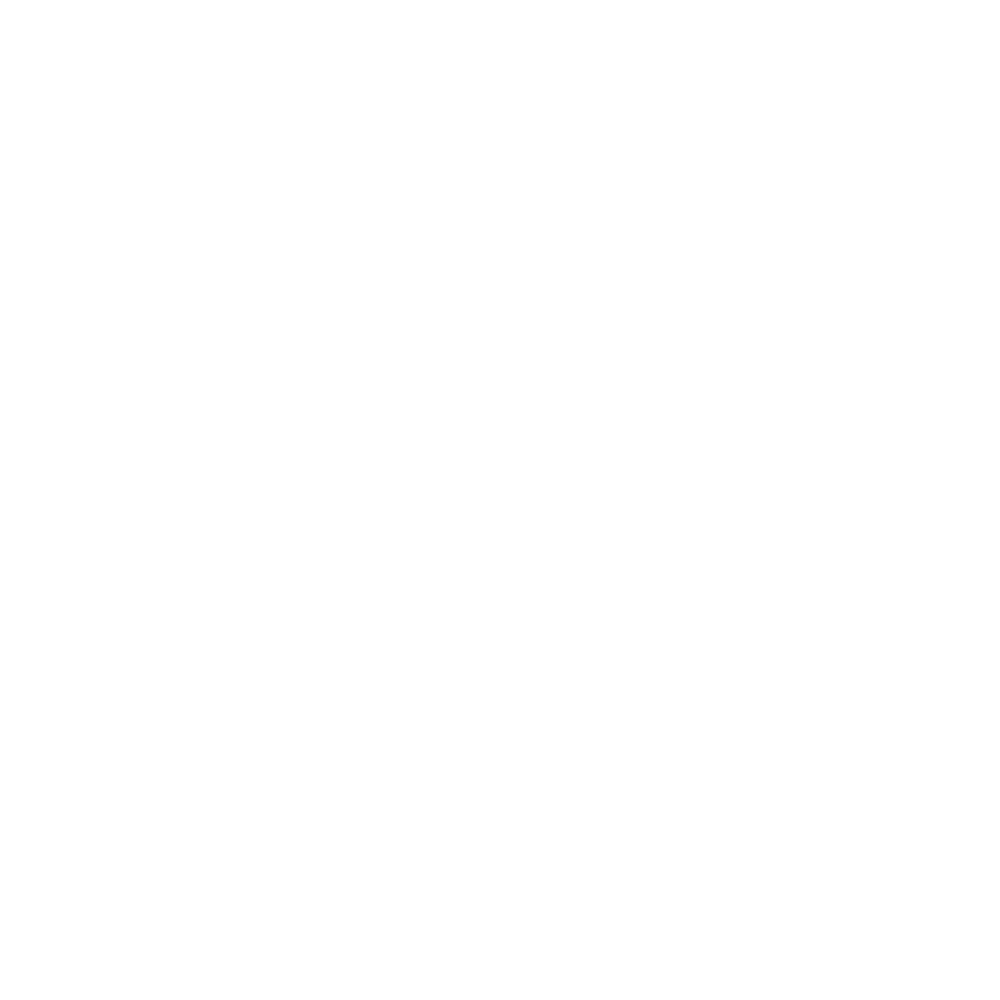

In [36]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

x = df_id_real_pred_3d.MSGFScore_pred.values
y = df_id_real_pred_3d.MSGFScore_real.values
z = df_id_real_pred_3d.Frequency.values
ax.scatter(x, y, z, alpha = 0.1, color='gray')

ax.set_xlabel('MSGFScore_pred')
ax.set_ylabel('MSGFScore_real')
ax.set_zlabel('Frequency')
plt.show()

# more feature
  - spectrum quality for 3d axis

In [37]:
pc2spec_pred = dict()
for p, c, mz, i in df_id_real_pred[['PEP', 'CHA', 'MZ_pred', 'INT_pred']].values:
    if (p, c) not in pc2spec_pred:
        pc2spec_pred[(p,c)]=dict()
    mz = list(map(lambda x: int(float(x)), mz.split(';')))
    i = list(map(float, i.split(';')))
    for mz_, i_ in zip(mz, i):
        pc2spec_pred[(p,c)][mz_] = i_

In [38]:
pc2spec_real = dict()
for p, c, mz, i in df_id_real_pred[['PEP', 'CHA', 'MZ_real', 'INT_real']].values:
    if (p, c) not in pc2spec_real:
        pc2spec_real[(p,c)]=dict()
    mz = list(map(lambda x: int(float(x)), mz.split(';')))
    i = list(map(float, i.split(';')))
    for mz_, i_ in zip(mz, i):
        pc2spec_real[(p,c)][mz_] = i_

In [39]:
def viz_spec(idx):
    mp, ip, mr, ir, score_p, score_r, pep, cha = df_id_real_pred.iloc[idx][['MZ_pred', 'INT_pred', 'MZ_real', 'INT_real',
                                                                'MSGFScore_pred', 'MSGFScore_real',
                                                               'PEP', 'CHA']].values
    pred_dic = {k:v for k, v in zip(list(map(lambda x: int(float(x)), mp.split(';'))),
                                     list(map(float, ip.split(';'))))}
    pred_arr = np.array(sorted(pred_dic.items()))
    real_dic = {k:v for k, v in zip(list(map(lambda x: int(float(x)), mr.split(';'))),
                                     list(map(lambda x: -float(x) / max(list(map(float, ir.split(';')))), ir.split(';'))))}
    real_arr = np.array(sorted(real_dic.items()))

    plt.figure(figsize=(18,5))
    plt.bar(pred_arr[:, 0],
           pred_arr[:, 1],
            color='darkblue',
    #        ec='none',
           edgecolor='darkblue')
    plt.bar(real_arr[:, 0],
           real_arr[:, 1],
            color='red',
    #        ec='none',
           edgecolor='red')

    plt.title('pred - real MS2 spectrum  ' + pep + str(cha))
    plt.legend(['predMSGF: '+str(score_p), 'realMSGF: '+str(score_r)])
    plt.xlabel('m/z')
    plt.ylabel('intensitiy')
    plt.show()

In [40]:
def norm2(vec):
    return sum([_**2 for _ in vec])**0.5
def dotproduct(v1, v2):
    return sum(np.array(v1)*np.array(v2))
def vec2norm(vec):
    return np.array(vec) / (sum([_**2 for _ in vec])**0.5)
def vec2r_(v1, v2):
    return stats.pearsonr(v1, v2)
def vec2r(v1, v2):
    v1_mean = sum(v1)/len(v1)
    v2_mean = sum(v2)/len(v2)
    
    covdot = dotproduct(np.array(v1)-v1_mean, np.array(v2)-v2_mean)
    v1_std = sum([(_-v1_mean)**2 for _ in v1])**0.5
    v2_std = sum([(_-v2_mean)**2 for _ in v2])**0.5
    return round(covdot / (v1_std*v2_std), 2)

def inv_cos(scalar):
    return math.acos(scalar)

def vec2sa(v1, v2):
    # normalized spectral contrast angle
    v1 = vec2norm(v1)
    v2 = vec2norm(v2)
    # 1 : same vector v1,v2 (high corr) , 0 : low corr (angle theta = 90 degree)
    return round(1 - (2*inv_cos(dotproduct(v1, v2))) / math.pi, 2)

def get_spectrum(pep2spec_pred, pep2spec_expe):
    
    # get whole spectrum prediction
    whole_pep2spec_pred = dict()
    
    for pc, mz2int in pep2spec_pred.items():
        c_pred = dict()
        # scaling int scale
        for mz, i in zip(list(mz2int.keys()),
                         list(mz2int.values())):
            if int(mz) not in c_pred:
                c_pred[int(mz)]=[]
            c_pred[int(mz)].append(i)
        for k, v in c_pred.items():
            c_pred[k] = max(v)
            
        whole_pep2spec_pred[pc] = c_pred
        
    # get whole spectrum experiment
    whole_pep2spec_expe = dict()
    
    for pc, mz2int in pep2spec_expe.items():
        c_expe = dict()
        # initialize with prediction spectrum m/z
        for init_k in whole_pep2spec_pred[pc].keys():
            c_expe[init_k] = [0]
        # scaling int scale
        for mz, i in zip(list(mz2int.keys()), 
                        list(mz2int.values())):
            if int(mz) in whole_pep2spec_pred[pc].keys():
                c_expe[int(mz)].append(i)
        for k, v in c_expe.items():
            c_expe[k] = max(v)

        max4norm = max(c_expe.items(), key=lambda x: x[1])[1]
        for k, v in c_expe.items():
            if max4norm != 0:
                c_expe[k] = v / max4norm
            else:
                c_expe[k] = v
        
        whole_pep2spec_expe[pc] = c_expe

    return whole_pep2spec_pred, whole_pep2spec_expe

In [41]:
wpc2spec_pred, wpc2spec_real = get_spectrum(pc2spec_pred, pc2spec_real)

In [42]:
prosit_eval = dict()
for pc, mz2int_pred in wpc2spec_pred.items():
    mz2int_real = wpc2spec_real[pc]
    v1 = list(mz2int_pred.values())
    v2 = list(mz2int_real.values())
    
    if pc not in prosit_eval:
        prosit_eval[pc] = dict()
    prosit_eval[pc]['R'] = round(vec2r_(v1, v2)[0], 2)
    prosit_eval[pc]['SA'] = vec2sa(v1, v2)

In [43]:
r_viz = [_['R'] for _ in prosit_eval.values()]
sa_viz = [_['SA'] for _ in prosit_eval.values()]

In [44]:
%matplotlib inline

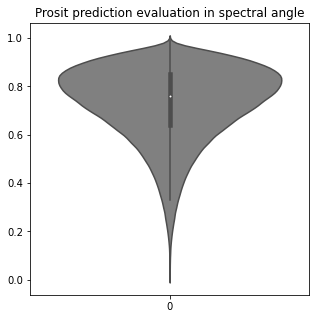

In [45]:
plt.figure(figsize=(5,5))
sns.violinplot(data=sa_viz, color='gray')
plt.title('Prosit prediction evaluation in spectral angle')
plt.show()

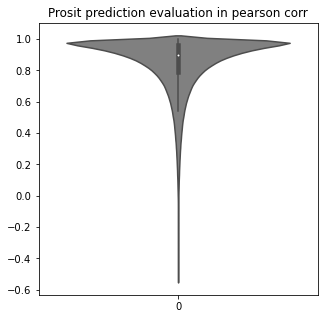

In [46]:
plt.figure(figsize=(5,5))
sns.violinplot(data=r_viz, color='gray')
plt.title('Prosit prediction evaluation in pearson corr')
plt.show()

* see one by one

In [47]:
df_id_real_pred.loc[(df_id_real_pred.MSGFScore_pred<=50) & (df_id_real_pred.MSGFScore_real>=300)].head(2)

,Precursor_pred,IsotopeError_pred,PrecursorError(ppm)_pred,Peptide_pred,Protein_pred,MSGFScore_pred,SpecEValue_pred,EValue_pred,MZ_pred,INT_pred,PEP,CHA,Precursor_real,IsotopeError_real,PrecursorError(ppm)_real,Peptide_real,Protein_real,MSGFScore_real,SpecEValue_real,EValue_real,MZ_real,INT_real
247514,1050.8154,0,-0.116167,GQISGEEASDEGEVQGQSQGSSPSFNNLRR,"sp|Q3SY00|T10IP_HUMAN(pre=K,post=R)",5,2.704545e-09,0.074832,175.118952167;1003.5431871669999;1234.62870716...,0.09864078;0.008376792;0.0076534427;0.00521764...,GQISGEEASDEGEVQGQSQGSSPSFNNLRR,3,1050.8154,0,-0.116167,GQISGEEASDEGEVQGQSQGSSPSFNNLRR,"sp|Q3SY00|T10IP_HUMAN(pre=K,post=R)",339,3.552152e-25,9.828428e-18,129.06591796875;141.06593322753906;152.0342864...,56391.62109375;33715.17578125;27058.90234375;2...
299695,1009.8368,0,0.000000,AVDADSGYNAWLSYELQSAAVGARIPFR,"sp|Q9Y5I2|PCDAA_HUMAN(pre=R,post=V)",43,7.823829e-13,0.000021,175.118952167;419.240130167;532.3241941670001;...,0.17867157;0.08115616;0.009228736;0.021744378;...,AVDADSGYNAWLSYELQSAAVGARIPFR,3,1009.8368,0,0.000000,AVDADSGYNAWLSYELQSAAVGARIPFR,"sp|Q9Y5I2|PCDAA_HUMAN(pre=R,post=V)",311,1.088163e-23,2.980386e-16,129.10226440429688;136.075927734375;143.118148...,49320.89453125;45807.59765625;876065.75;55404....


In [48]:
df_id_real_pred.loc[(df_id_real_pred.MSGFScore_pred>=300) & (df_id_real_pred.MSGFScore_real<=50)].head(2)

,Precursor_pred,IsotopeError_pred,PrecursorError(ppm)_pred,Peptide_pred,Protein_pred,MSGFScore_pred,SpecEValue_pred,EValue_pred,MZ_pred,INT_pred,PEP,CHA,Precursor_real,IsotopeError_real,PrecursorError(ppm)_real,Peptide_real,Protein_real,MSGFScore_real,SpecEValue_real,EValue_real,MZ_real,INT_real
2812,1150.0435,0,0.0,HVPDLESGSESGADTISVNQTR,"sp|Q96QB1|RHG07_HUMAN(pre=R,post=V)",306,6.887694e-28,1.825690e-20,175.118952167;276.166631167;404.225209167;518....,0.05233014;0.027772648;0.01977404;0.113255404;...,HVPDLESGSESGADTISVNQTR,2,1150.0435,0,0.0,HVPDLESGSESGADTISVNQTR,"sp|Q96QB1|RHG07_HUMAN(pre=R,post=V)",33,8.740186e-12,0.000232,110.07097625732422;129.1012725830078;175.11897...,17949.966796875;13417.041015625;12856.109375;1...
62235,1334.1666,0,0.0,SIELDGTFVGAEAPGELGGLGPGPAEAR,"sp|Q9UPR5|NAC2_HUMAN(pre=K,post=E);tr|F5H6L7|F...",300,9.906272e-34,2.713243e-26,175.118952167;246.156066167;375.198659167;446....,0.050410394;0.11948212;0.00024028933;0.0058154...,SIELDGTFVGAEAPGELGGLGPGPAEAR,2,1334.1666,0,0.0,SIELDGTFVGAEAPGELGGLGPGPAEAR,"sp|Q9UPR5|NAC2_HUMAN(pre=K,post=E);tr|F5H6L7|F...",38,2.763391e-13,0.000008,173.12828063964844;246.1554718017578;330.16607...,365.72381591796875;350.1393737792969;686.14575...


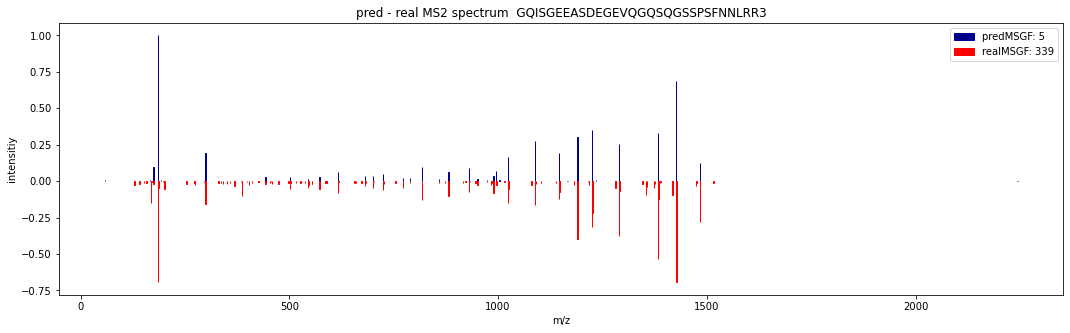

In [49]:
viz_spec(247514)

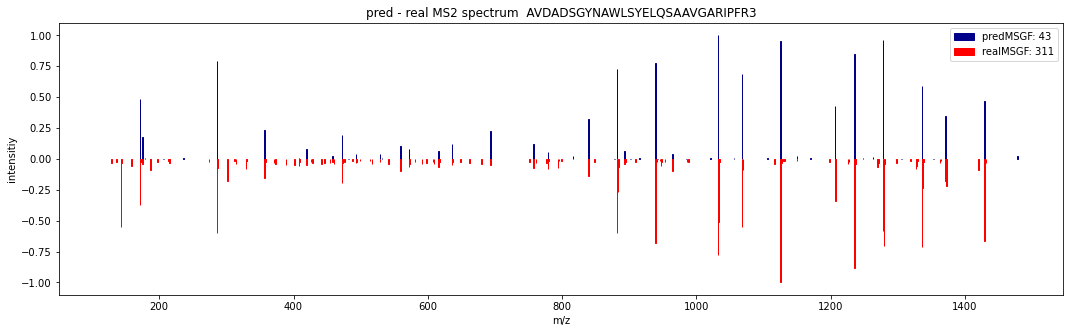

In [50]:
viz_spec(299695)

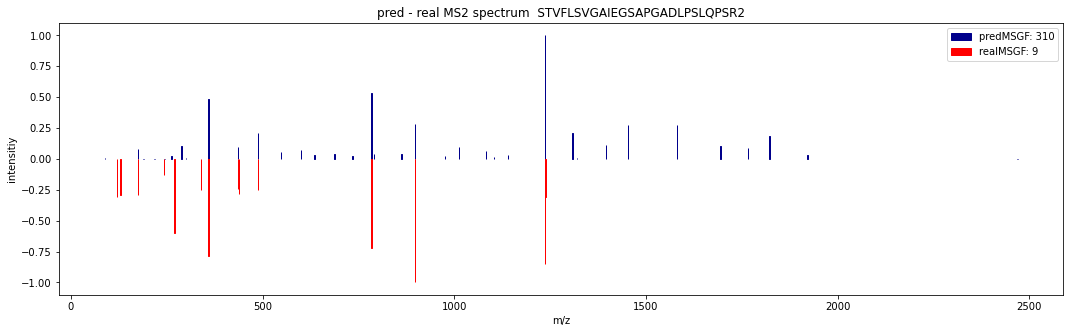

In [51]:
viz_spec(559114)

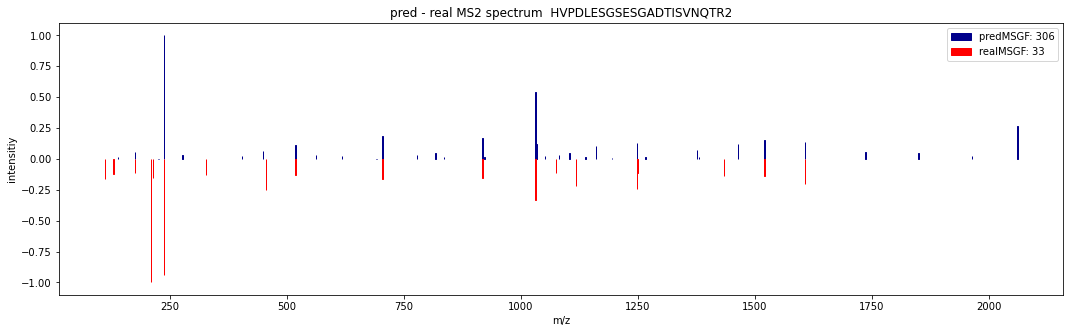

In [52]:
viz_spec(2812)

# 3d : spectrum angle axis add

In [53]:
df_id_real_pred.head(1)

,Precursor_pred,IsotopeError_pred,PrecursorError(ppm)_pred,Peptide_pred,Protein_pred,MSGFScore_pred,SpecEValue_pred,EValue_pred,MZ_pred,INT_pred,PEP,CHA,Precursor_real,IsotopeError_real,PrecursorError(ppm)_real,Peptide_real,Protein_real,MSGFScore_real,SpecEValue_real,EValue_real,MZ_real,INT_real
0,1148.5422,0,0.0,ILGWGVENGTPYWLVANSWNTDWGDNGFFK,"sp|P07858|CATB_HUMAN(pre=R,post=I);tr|R4GMQ5|R...",213,3.842356e-39,1.063139e-31,147.112804167;294.18121816699994;441.249632166...,0.24706785;0.4907155;0.21187675;0.36394352;0.4...,ILGWGVENGTPYWLVANSWNTDWGDNGFFK,3,1148.5422,0,0.0,ILGWGVENGTPYWLVANSWNTDWGDNGFFK,"sp|P07858|CATB_HUMAN(pre=R,post=I);tr|R4GMQ5|R...",79,2.073257e-16,5.736481e-09,120.08077239990234;126.05509185791016;129.1025...,23000.103515625;14412.4521484375;16642.2246093...


In [54]:
print(df_id_real_pred.shape[0],
      len({(p,c) for p, c in df_id_real_pred[['PEP' ,'CHA']].values}))

744033 744033


In [55]:
%matplotlib notebook

In [56]:
df_3d_angle = pd.DataFrame([[msgfp, msgfr, prosit_eval[(p,c)]['R']]
                            for msgfp, msgfr, p, c in df_id_real_pred[['MSGFScore_pred', 'MSGFScore_real', 'PEP', 'CHA']].values],
                          columns=['MSGFScore_pred', 'MSGFScore_real', 'SpectrumAngle'])

<IPython.core.display.Javascript object>


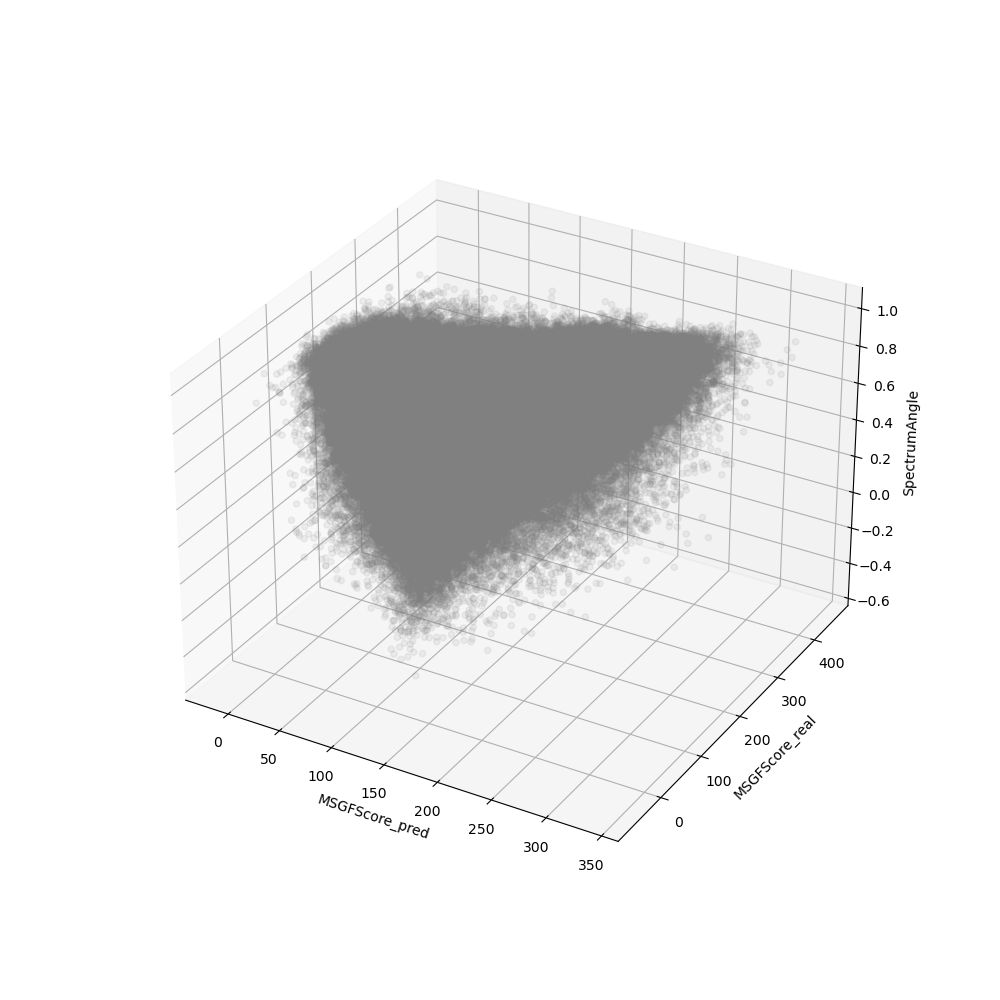

In [57]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

x = df_3d_angle.MSGFScore_pred.values
y = df_3d_angle.MSGFScore_real.values
z = df_3d_angle.SpectrumAngle.values
ax.scatter(x, y, z, alpha = 0.1, color='gray')

ax.set_xlabel('MSGFScore_pred')
ax.set_ylabel('MSGFScore_real')
ax.set_zlabel('SpectrumAngle')
plt.show()